## Dogs Cats Classification
We will build a convnet (convolutional neural network) to recognize and differentiate between cats and dogs.

In [ ]:
! pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download contest data
! kaggle competitions download -c dogs-vs-cats
! unzip -qq dogs-vs-cats.zip
! unzip -qq train.zip

 99% 801M/812M [00:06<00:00, 274MB/s]
100% 812M/812M [00:06<00:00, 135MB/s]


In [ ]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
print(original_dir)
print(new_base_dir)

train
cats_vs_dogs_small


Separate data into training data, validation data, and test data

In [ ]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames: shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Now, we define the model:

In [ ]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Let's take a look at the model's architecture:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
	print("data batch shape:", data_batch.shape)
	print("labels batch shape:", labels_batch.shape)
	break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


We will use a callback to save the best performing version of the model on validation data

In [ ]:
callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="convnet_from_scratch.keras",
		save_best_only=True,
		monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 82ms/step - loss: 0.6954 - accuracy: 0.5030 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 6s 86ms/step - loss: 0.6962 - accuracy: 0.5235 - val_loss: 0.6889 - val_accuracy: 0.5660
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6711 - accuracy: 0.5960 - val_loss: 0.6332 - val_accuracy: 0.6370
Epoch 4/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6241 - accuracy: 0.6490 - val_loss: 0.6332 - val_accuracy: 0.6470
Epoch 5/30
63/63 [==============================] - 7s 108ms/step - loss: 0.5962 - accuracy: 0.6910 - val_loss: 0.6062 - val_accuracy: 0.6660
Epoch 6/30
63/63 [==============================] - 4s 62ms/step - loss: 0.5679 - accuracy: 0.7085 - val_loss: 0.6043 - val_accuracy: 0.6760
Epoch 7/30
63/63 [==============================] - 4s 58ms/step - loss: 0.5396 - accuracy: 0.7280 - val_loss: 0.6086 - val_accuracy: 0.6740
Epoch 8/30


Now that we've trained our naive convnet, let's see its performance over-time:

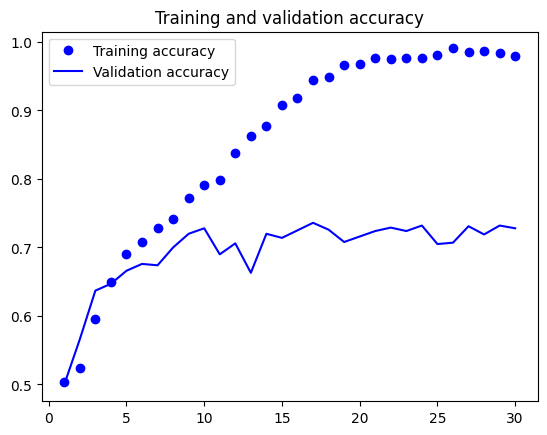

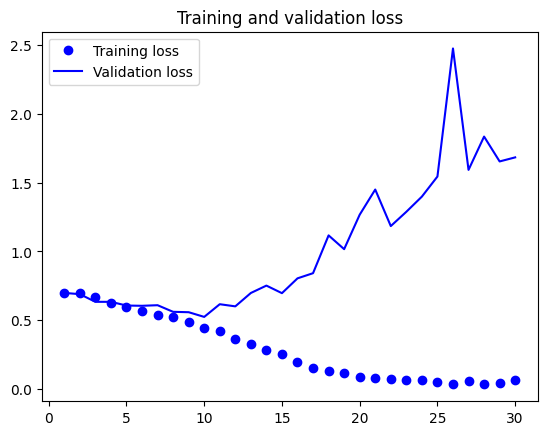

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


So, we've obviously over-fit by quite a lot, which is what we were aiming to do. We'll now reload the model from its saved file, to evaluate it as it was before it started over-fitting

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 37ms/step - loss: 0.5411 - accuracy: 0.7330
Test accuracy: 0.733


Since we only hae 2,000 training samples, which is relatively few, our main concern is over-fitting. We've seen methods of regularization such as L1, L2, and dropdown. We'll use data augmentation, which is used almost universally when it comes to processing images with deep learning models.

In [ ]:
data_augmentation = keras.Sequential(
	[
		layers.RandomFlip("horizontal"),
		layers.RandomRotation(0.1),
		layers.RandomZoom(0.2),
	]
)

Let's visualize these augmentations:

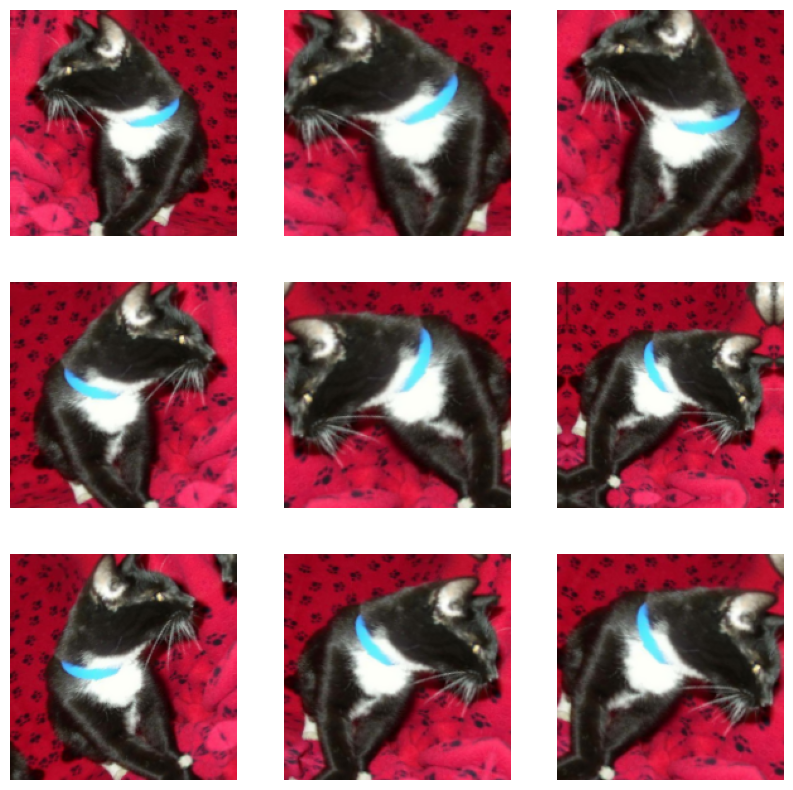

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Let's add data augmentation to the model, as well as a `Dropout` layer at end to regularize the model:

In [16]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Now, let's retrain the model, but with dropout and augmentation, we expect the over-fitting to occur much later during training

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/100
63/63 [==============================] - 7s 67ms/step - loss: 0.6947 - accuracy: 0.4920 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6937 - accuracy: 0.5355 - val_loss: 0.6925 - val_accuracy: 0.5030
Epoch 3/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6825 - accuracy: 0.5570 - val_loss: 0.7531 - val_accuracy: 0.5360
Epoch 4/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6687 - accuracy: 0.6015 - val_loss: 0.6594 - val_accuracy: 0.5850
Epoch 5/100
63/63 [==============================] - 7s 113ms/step - loss: 0.6550 - accuracy: 0.6505 - val_loss: 0.6395 - val_accuracy: 0.6260
Epoch 6/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6175 - accuracy: 0.6525 - val_loss: 0.6326 - val_accuracy: 0.6090
Epoch 7/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6237 - accuracy: 0.6510 - val_loss: 0.5954 - val_accuracy: 0.6460
Epoc

Let's plot again:

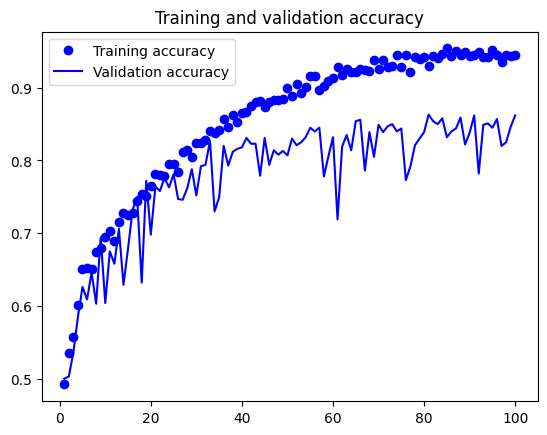

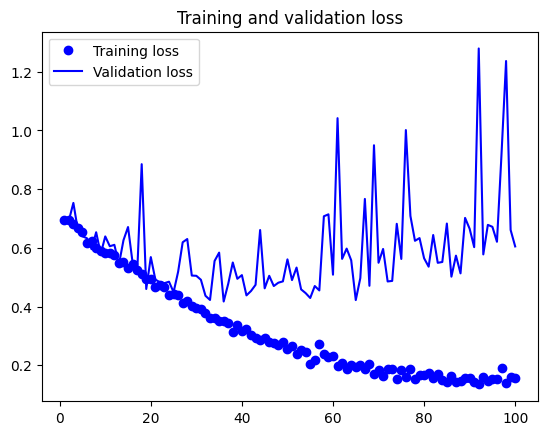

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let's check the test accuracy by loading in best performing model:

In [19]:
test_model = keras.models.load_model(
            "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 54ms/step - loss: 0.4365 - accuracy: 0.8135
Test accuracy: 0.813
